In [2]:
import os
from classes.VAE import VAEGAN

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor,Resize,PILToTensor
from torchvision.io import read_image
from torchsummary import summary

from torch import distributions as D
import wandb

from imutils import paths
import matplotlib.pyplot as plt
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante (use `wandb login --relogin` to force relogin)


True

In [29]:
encoder_architecture=[[0,512],[1,256],[1,128],[1,64]]
decoder_architecture=[[0,64],[0,128],[0,256],[0,512]]

discriminator_architecture=[[0,64],[0,128],[0,256],[0,512]]
discriminator_dense=64
latent_dim=1024
input_dim=(3,128,128)


config={"dataset":"CelebA", "type":"VAEGAN","encoder_architecture":encoder_architecture,"decoder_architecture":decoder_architecture,"discriminator_architecture":discriminator_architecture}
config["latent_dim"]=latent_dim
config["input_dim"]=input_dim

model=VAEGAN(input_dim=input_dim,latent_dim=latent_dim,encoder_architecture=encoder_architecture,decoder_architecture=decoder_architecture,discriminator_architecture=discriminator_architecture,discriminator_dense=discriminator_dense)

#model=VAE(input_dim,latent_dim)

In [30]:
images_dir=r"C:\Users\matte\Dataset\tor_vergata\Dataset\Img\img_align_celeba"
images_dir=r"/home/matteo/NeuroGEN/Dataset/Img/img_align_celeba"

#other important definitions

EPOCHS=30
BS=128
INIT_LR=1e-4

config["epochs"]=EPOCHS
config["BS"]=BS
config["init_lr"]=INIT_LR


In [31]:
summary(model.vae.encoder,(3,128,128),device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 64, 64]          25,088
      ConvResBlock-2          [-1, 512, 64, 64]               0
            Conv2d-3          [-1, 256, 32, 32]       2,097,408
            Conv2d-4          [-1, 256, 32, 32]         590,080
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 256, 32, 32]         590,080
       BatchNorm2d-7          [-1, 256, 32, 32]             512
              ReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         590,080
      BatchNorm2d-10          [-1, 256, 32, 32]             512
        LeakyReLU-11          [-1, 256, 32, 32]               0
    ResidualBlock-12          [-1, 256, 32, 32]               0
     ConvResBlock-13          [-1, 256, 32, 32]               0
           Conv2d-14          [-1, 128,

In [32]:
summary(model.vae.decoder,(latent_dim,),device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]       4,198,400
         Unflatten-2             [-1, 64, 8, 8]               0
   ConvTranspose2d-3           [-1, 64, 16, 16]          65,600
             PReLU-4           [-1, 64, 16, 16]               1
ConvTransposeResBlock-5           [-1, 64, 16, 16]               0
   ConvTranspose2d-6          [-1, 128, 32, 32]         131,200
             PReLU-7          [-1, 128, 32, 32]               1
ConvTransposeResBlock-8          [-1, 128, 32, 32]               0
   ConvTranspose2d-9          [-1, 256, 64, 64]         524,544
            PReLU-10          [-1, 256, 64, 64]               1
ConvTransposeResBlock-11          [-1, 256, 64, 64]               0
  ConvTranspose2d-12        [-1, 512, 128, 128]       2,097,664
            PReLU-13        [-1, 512, 128, 128]               1
ConvTransposeResBlock-14     

In [33]:
summary(model.discriminator,(3,128,128),device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
      ConvResBlock-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,200
      ConvResBlock-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 256, 16, 16]         524,544
      ConvResBlock-6          [-1, 256, 16, 16]               0
            Conv2d-7            [-1, 512, 8, 8]       2,097,664
      ConvResBlock-8            [-1, 512, 8, 8]               0
           Flatten-9                [-1, 32768]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                   [-1, 64]       2,097,216
           Linear-12                   [-1, 64]       2,097,216
          Dropout-13                   [-1, 64]               0
          Dropout-14                   

## Dataloaders

In [34]:
class ImageDataset(Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)/255.
        return image


In [35]:
transforms=Compose([
 Resize((128,128)),
])



In [36]:
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(images_dir))


train_len=int(0.8*len(imagePaths))  #0.8
val_len=int(0.1*len(imagePaths))     #0.1
test_len=int(0.1*len(imagePaths))

train_imgs=imagePaths[:train_len]                                #      80% for training
val_imgs=imagePaths[train_len:train_len+val_len]                 #      10% for validation
test_imgs=imagePaths[train_len+val_len:]                         #      10% for testing

print(f"[TRAINING]\t {len(train_imgs)}\n[VALIDATION]\t {len(val_imgs)}\n[TEST]\t\t {len(test_imgs)}")

[INFO] loading image paths...
[TRAINING]	 138545
[VALIDATION]	 17318
[TEST]		 17319


In [37]:
train_dataset=ImageDataset(train_imgs,transform=transforms)
val_dataset=ImageDataset(val_imgs,transform=transforms)
test_dataset=ImageDataset(test_imgs,transform=transforms)

train_dataloader=DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=BS)
test_dataloader=DataLoader(test_dataset, batch_size=BS)


## Train Loop

In [38]:
base_path="models/vaegan"
os.makedirs(base_path,exist_ok=True)

In [39]:
# Get cpu or gpu device for training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


In [40]:
wandb.init(project="NeuroGEN_Pytorch",config=config)

Epoch 0: 100%|█| 1083/1083 [53:15<00:00,  2.95s/batch, d_loss=0.536, g_loss=0.92
Val 0: 100%|█| 136/136 [04:32<00:00,  2.00s/batch, d_accuracy=0, d_loss=0.533, l


(39, 128, 128, 3) (39, 128, 128, 3)


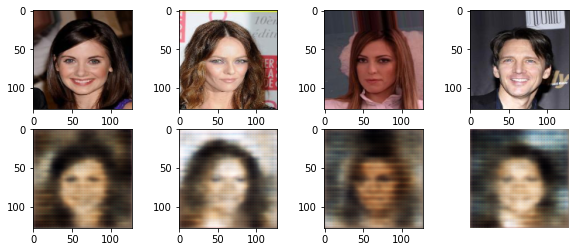

Epoch 1: 100%|█| 1083/1083 [24:42<00:00,  1.37s/batch, d_loss=0.699, g_loss=0.76
Val 1: 100%|█| 136/136 [01:08<00:00,  2.00batch/s, d_accuracy=0, d_loss=0.706, l


(39, 128, 128, 3) (39, 128, 128, 3)


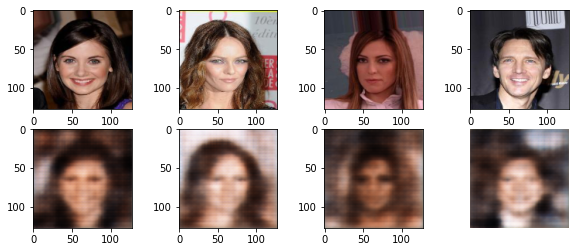

Epoch 2: 100%|█| 1083/1083 [24:36<00:00,  1.36s/batch, d_loss=0.628, g_loss=0.71
Val 2: 100%|█| 136/136 [01:08<00:00,  2.00batch/s, d_accuracy=0, d_loss=0.613, l


(39, 128, 128, 3) (39, 128, 128, 3)


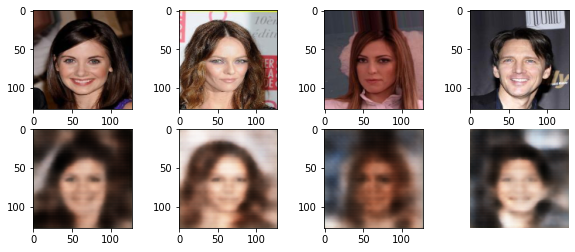

Epoch 3: 100%|█| 1083/1083 [24:37<00:00,  1.36s/batch, d_loss=0.669, g_loss=0.64
Val 3: 100%|█| 136/136 [01:08<00:00,  1.99batch/s, d_accuracy=0, d_loss=0.692, l


(39, 128, 128, 3) (39, 128, 128, 3)


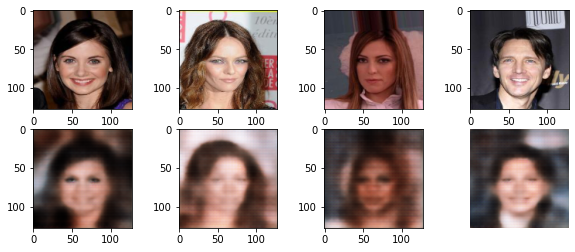

Epoch 4: 100%|█| 1083/1083 [24:32<00:00,  1.36s/batch, d_loss=0.689, g_loss=0.71
Val 4: 100%|█| 136/136 [01:08<00:00,  1.99batch/s, d_accuracy=0, d_loss=0.685, l


(39, 128, 128, 3) (39, 128, 128, 3)


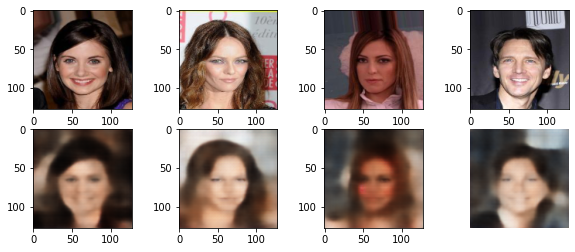

Epoch 5: 100%|█| 1083/1083 [24:31<00:00,  1.36s/batch, d_loss=0.687, g_loss=0.68
Val 5: 100%|█| 136/136 [01:08<00:00,  2.00batch/s, d_accuracy=0, d_loss=0.688, l


(39, 128, 128, 3) (39, 128, 128, 3)


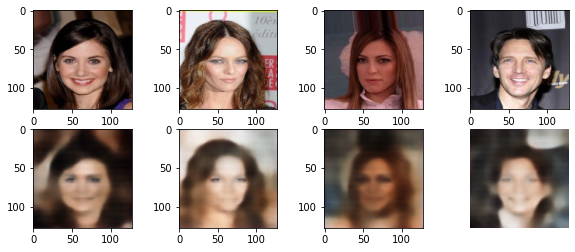

Epoch 6: 100%|█| 1083/1083 [24:35<00:00,  1.36s/batch, d_loss=0.681, g_loss=0.71
Val 6: 100%|█| 136/136 [01:08<00:00,  2.00batch/s, d_accuracy=0, d_loss=0.66, lo


(39, 128, 128, 3) (39, 128, 128, 3)


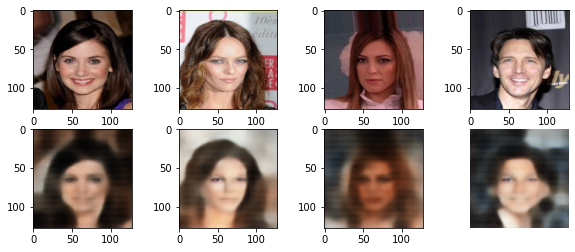

Epoch 7: 100%|█| 1083/1083 [24:40<00:00,  1.37s/batch, d_loss=0.631, g_loss=0.75
Val 7: 100%|█| 136/136 [01:08<00:00,  2.00batch/s, d_accuracy=0, d_loss=0.64, lo


(39, 128, 128, 3) (39, 128, 128, 3)


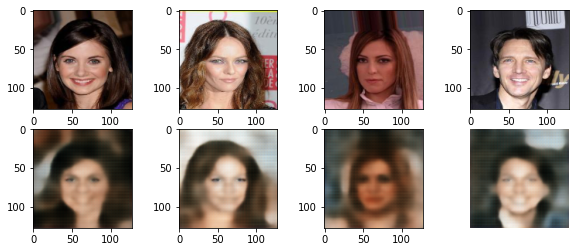

Epoch 8: 100%|█| 1083/1083 [24:35<00:00,  1.36s/batch, d_loss=0.707, g_loss=1.04
Val 8: 100%|█| 136/136 [01:08<00:00,  2.00batch/s, d_accuracy=0, d_loss=0.727, l


(39, 128, 128, 3) (39, 128, 128, 3)


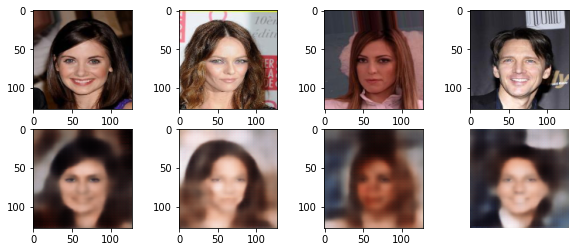

Epoch 9: 100%|█| 1083/1083 [24:35<00:00,  1.36s/batch, d_loss=0.707, g_loss=0.67
Val 9: 100%|█| 136/136 [01:07<00:00,  2.00batch/s, d_accuracy=0, d_loss=0.699, l


(39, 128, 128, 3) (39, 128, 128, 3)


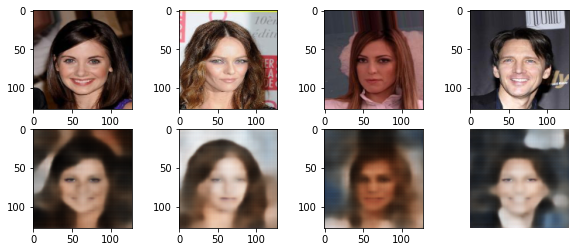

Epoch 10: 100%|█| 1083/1083 [24:42<00:00,  1.37s/batch, d_loss=0.761, g_loss=0.7
Val 10: 100%|█| 136/136 [01:08<00:00,  2.00batch/s, d_accuracy=0, d_loss=0.767, 


(39, 128, 128, 3) (39, 128, 128, 3)


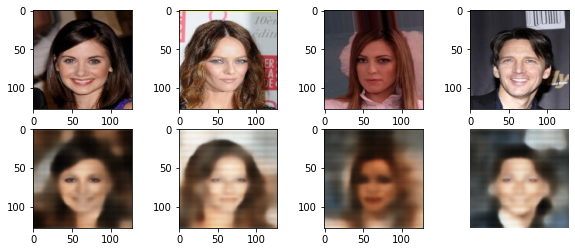

Epoch 11: 100%|█| 1083/1083 [24:38<00:00,  1.37s/batch, d_loss=0.473, g_loss=0.9
Val 11: 100%|█| 136/136 [01:08<00:00,  1.99batch/s, d_accuracy=0, d_loss=0.429, 


(39, 128, 128, 3) (39, 128, 128, 3)


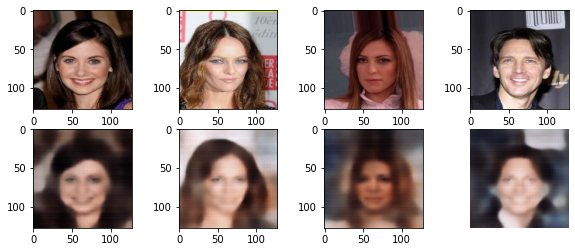

Epoch 12: 100%|█| 1083/1083 [24:33<00:00,  1.36s/batch, d_loss=0.69, g_loss=0.79
Val 12: 100%|█| 136/136 [01:08<00:00,  2.00batch/s, d_accuracy=0, d_loss=0.69, l


(39, 128, 128, 3) (39, 128, 128, 3)


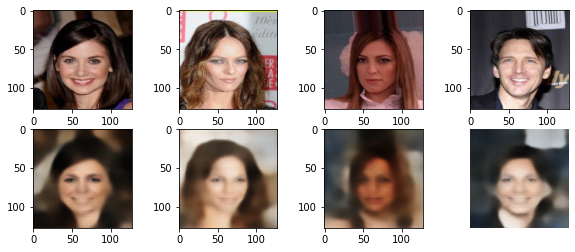

Epoch 13: 100%|█| 1083/1083 [24:32<00:00,  1.36s/batch, d_loss=0.54, g_loss=0.81
Val 13: 100%|█| 136/136 [01:08<00:00,  1.99batch/s, d_accuracy=0, d_loss=0.499, 

[INFO] Early Stopping


In [41]:

#model.load_state_dict(torch.load(r"models/vae/model.ckp"))

d_optimizer=torch.optim.Adam(model.discriminator.parameters(),lr=INIT_LR)
v_optimizer=torch.optim.Adam(model.vae.parameters(),lr=INIT_LR)
g_optimizer=torch.optim.Adam(model.vae.decoder.parameters(),lr=INIT_LR)

model.to(device)

model.fit(train_dataloader=train_dataloader,val_dataloader=test_dataloader,epochs=EPOCHS,d_optimizer=d_optimizer,v_optimizer=v_optimizer,g_optimizer=g_optimizer,device=device,wandb_log=True,save_model=base_path,early_stop=3)

In [42]:
x,y=next(iter(test_dataloader))

ValueError: too many values to unpack (expected 2)

In [ ]:
x2=model(x.to(device))

In [15]:
x2.shape

torch.Size([512, 1, 28, 28])

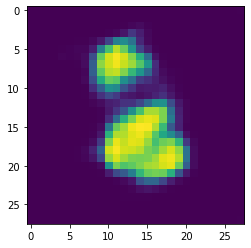

In [16]:
plt.imshow(x2[0].cpu().detach().permute(1,2,0).numpy())

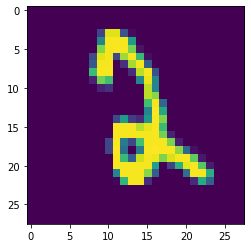

In [17]:
plt.imshow(x[0].cpu().permute(1,2,0).numpy()*255)